# Start

In [1]:
print("Hello")

Hello


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score, 
    mean_absolute_error, 
    mean_squared_error,
    confusion_matrix
)

# Function to evaluate the model and print metrics
def evaluate_model(model_name, model, test_generator):
    # Reset the generator to start from the beginning
    test_generator.reset()  
    
    # Get predictions
    y_pred_prob = model.predict(test_generator)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Binarize predictions
    y_true = test_generator.classes  # True labels

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    auc = roc_auc_score(y_true, y_pred_prob)

    # Calculate specificity
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Print metrics
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(f"Specificity: {specificity:.4f}\n")

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Benign', 'Malignant'],
                yticklabels=['Benign', 'Malignant'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.savefig(f'Confusion_{model_name}.png', format='png', dpi=600, bbox_inches="tight")
    plt.show()

# Breakhis-400x

In [3]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
history_fine = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 52s 729ms/step - accuracy: 0.5799 - loss: 0.8502 - val_accuracy: 0.6319 - val_loss: 0.6357
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6426 - loss: 0.6362 - val_accuracy: 0.8352 - val_loss: 0.5140
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.6826 - loss: 0.5881 - val_accuracy: 0.8242 - val_loss: 0.4835
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.7433 - loss: 0.5231 - val_accuracy: 0.8022 - val_loss: 0.5067
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.7393 - loss: 0.5172 - val_accuracy: 0.7802 - val_loss: 0.4861
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7349 - loss: 0.5209 - val_accuracy: 0.8132 - val_loss: 0.4732
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.7935 - loss: 0.4667 - val_accuracy: 0.8242 - val_loss: 0.4092
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.7903 - loss: 0.4352 - val_accuracy: 0.8516 - val

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 763ms/step
Model: DNBCD1
Accuracy: 0.9315
Precision: 0.9302
Recall: 0.9717
F1 Score: 0.9505
Mean Absolute Error: 0.0685
Root Mean Square Error: 0.2617
AUC Score: 0.9844
Specificity: 0.8475



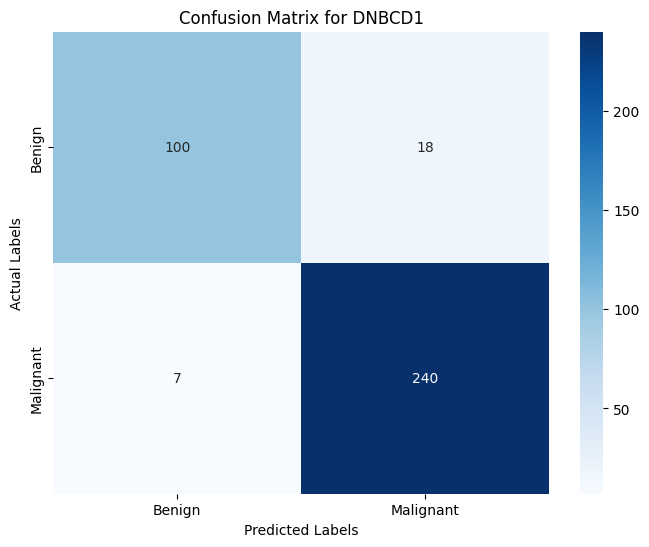

In [4]:
model_name= "DNBCD1"
evaluate_model(model_name,model, test_generator)

In [7]:
import os
import numpy as np
import cv2  # OpenCV for general use (not CLAHE)
import tensorflow as tf
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.utils.class_weight import compute_class_weight

# Define paths
dataset_path = '/kaggle/input/breakhis-400x/Breakhis-400x'
base_dir = '/kaggle/working/split_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Ensure clean split directories
for dir_path in [train_dir, val_dir, test_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)

# Split dataset into 70% train, 20% test, 10% validation
all_images = []
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    all_images.extend([(img, class_name) for img in images])

test_split = 0.2
val_split = 0.1
train_images, temp_images = train_test_split(
    all_images,
    test_size=(test_split + val_split),
    stratify=[label for _, label in all_images],
    random_state=42
)
val_images, test_images = train_test_split(
    temp_images,
    test_size=(test_split / (test_split + val_split)),
    stratify=[label for _, label in temp_images],
    random_state=42
)

# Copy files into respective directories without preprocessing
def copy_images(images, target_dir):
    for img_path, label in images:
        label_dir = os.path.join(target_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(img_path, label_dir)  # Copy the original image without preprocessing

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

# Parameters
input_shape = (128, 128, 3)
batch_size = 32
epochs = 20

# Create data generators for binary classification
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary'  # Binary classification
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=False
)

# Print the number of samples in each split
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

# Compute class weights
train_labels = train_generator.classes  # Class indices for training samples
class_names = list(train_generator.class_indices.keys())
class_weights = compute_class_weight(
    class_weight='balanced',  # Balance classes based on their frequency
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

# Print the calculated class weights
print("Class Weights:", class_weights)

# Load pre-trained DenseNet121 model + higher-level layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights  # Use calculated class weights
)

# Unfreeze the base model for fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])  # Reduce learning rate for fine-tuning

# Fine-tune the model with class weights
history_fine = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print('Loss:', loss)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Found 1273 images belonging to 2 classes.
Found 182 images belonging to 2 classes.
Found 365 images belonging to 2 classes.
Training samples: 1273
Validation samples: 182
Test samples: 365
Class Weights: {0: 1.548661800486618, 1: 0.738399071925754}
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 39s 521ms/step - accuracy: 0.5654 - loss: 0.9138 - val_accuracy: 0.7527 - val_loss: 0.5591
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.6484 - loss: 0.6570 - val_accuracy: 0.8297 - val_loss: 0.4861
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.7243 - loss: 0.5852 - val_accuracy: 0.8242 - val_loss: 0.5036
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.7427 - loss: 0.5554 - val_accuracy: 0.8187 - val_loss: 0.4656
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 0.8007 - loss: 0.4410 - val_accuracy: 0.8242 - val_loss: 0.4142
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.7496 - loss: 0.5057 - val_accuracy: 0.8407 - val_loss: 0.4112
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.7922 - loss: 0.4447 - val_accuracy: 0.8242 - val_loss: 0.4262
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 0.8077 - loss: 0.4211 - val_accuracy: 0.8462 - val

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 612ms/step
Model: DNBCD3
Accuracy: 0.9479
Precision: 0.9711
Recall: 0.9514
F1 Score: 0.9611
Mean Absolute Error: 0.0521
Root Mean Square Error: 0.2282
AUC Score: 0.9902
Specificity: 0.9407



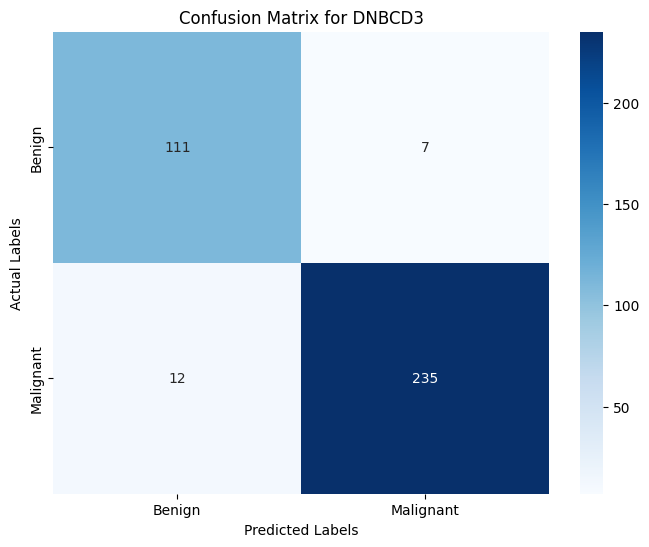

In [8]:
model_name= "DNBCD3"
evaluate_model(model_name,model, test_generator)